In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import datetime

import sys
sys.path.append('../../identification/')

from scipy.signal import medfilt

import keras.backend as K
from sklearn.model_selection import train_test_split

In [2]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

## Prepare dataset and label

In [3]:
mms = np.load('/DATA/nguyen/timeSeries_interval/MMS_FR_non_centered.npy', allow_pickle=True)

In [4]:
cluster = np.load('/DATA/nguyen/timeSeries_interval/Cluster_FR_non_centered.npy', allow_pickle=True)

In [5]:
MSH_no_FR_cluster = np.load('/DATA/nguyen/timeSeries_interval/MSH_Cluster.npy', allow_pickle=True)
MSH_no_FR_mms = np.load('/DATA/nguyen/timeSeries_interval/MSH_MMS.npy', allow_pickle=True)

In [6]:
MSH_no_FR_mms.shape

(100, 2080, 3)

In [6]:
total_time_series = len(mms)+len(cluster)+len(MSH_no_FR_cluster)+len(MSH_no_FR_mms)

In [7]:
X = np.zeros((total_time_series, mms.shape[1], mms.shape[2]+1))


for i, x in enumerate(mms):
    mag = np.linalg.norm(x, axis=1)
    X[i,:, :3] = x/max(mag)
    X[i, :, 3] = mag/max(mag)
    
for i, x in enumerate(cluster):
    mag = np.linalg.norm(x, axis=1)
    X[i+len(mms),:, :3] = x/max(mag)
    X[i+len(mms),:, 3] = mag/max(mag)   
    
for i, x in enumerate(MSH_no_FR_cluster):
    mag = np.linalg.norm(x, axis=1)
    X[i+len(mms)+len(cluster),:, :3] = x/max(mag)
    X[i+len(mms)+len(cluster),:, 3] = mag/max(mag)    
    
for i, x in enumerate(MSH_no_FR_mms):
    mag = np.linalg.norm(x, axis=1)
    X[i+len(mms)+len(cluster)+len(MSH_no_FR_cluster),:, :3] = x/max(mag)
    X[i+len(mms)+len(cluster)+len(MSH_no_FR_cluster),:, 3] = mag/max(mag)  


In [8]:
y_cluster = np.load('/DATA/nguyen/timeSeries_interval/Cluster_FR_label_non_centered.npy', allow_pickle=True)
y_mms = np.load('/DATA/nguyen/timeSeries_interval/MMS_label_non_centered.npy', allow_pickle=True)
y_msh_no_fr = np.zeros((len(MSH_no_FR_cluster)+len(MSH_no_FR_mms), 2080))

In [9]:
Y = np.zeros((len(X), X.shape[1], 1))


for i, x in enumerate(y_mms):
    Y[i, :, 0] = x
    
for i, x in enumerate(y_cluster):
    Y[i+len(y_mms), :, 0] = x
    
for i, x in enumerate(y_msh_no_fr):
    Y[i+len(y_mms)+len(cluster), :, 0] = x

In [10]:
Y.shape

(539, 2080, 1)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, Y)
X_train_flipped = np.append(X_train,  np.flip(X_train, 1), axis=0)
y_train_flipped = np.append(y_train,  np.flip(y_train, 1), axis=0)

In [12]:
def create_label(arr):
    label = np.zeros((13, 3))
    diffs = np.where(np.diff(arr==1))[0]
    if arr[0]==1:
        diffs = np.insert(diffs, 0, 0)
    if arr[-1]==1:
        diffs = np.insert(diffs, len(diffs), len(arr)-1)
    begins = diffs[::2]/len(arr)
    ends = diffs[1::2]/len(arr)
    center = (ends+begins)/2


    loc_i = 13*center
    loc_i= loc_i.astype(int)
    width = ends-begins

    for i in range(len(loc_i)):
        label[loc_i[i], :] = [13*center[i]-loc_i[i], width[i], 1]    
    
    return label

In [13]:
def yoloss(y_true, y_pred):
    loc_loss = K.sum(K.expand_dims(y_true[..., 2])*K.square(y_true[..., :1]-y_pred[..., :1]))
    
    width_true = y_true[..., 1:2]
    width_pred = y_pred[..., 1:2]
    width_loss = K.sum(K.expand_dims(y_true[..., 2])*K.square(width_true-width_pred))
    
    proba_loss_object = K.sum(K.expand_dims(y_true[..., 2])*K.square(y_true[..., 2:]-y_pred[..., 2:]))
    
    proba_loss_no_object = K.sum(K.expand_dims(1-y_true[..., 2])*K.square(y_true[..., 2:]-y_pred[..., 2:]))
    
    return 2*loc_loss+2*width_loss+2*proba_loss_object+0.5*proba_loss_no_object

In [14]:
Y_labels = np.zeros((len(y_train_flipped), 13, 3))

for i in range(len(y_train_flipped)):
    Y_labels[i] = create_label(y_train_flipped[i, :, 0])

In [15]:
from keras.layers import LayerNormalization, Conv1D, Dense, BatchNormalization, concatenate, Dropout, Flatten, Conv1DTranspose, MaxPooling1D
from keras import Input, Model
from keras.activations import leaky_relu
import tensorflow as tf

In [16]:
inputs = Input((X.shape[1], X.shape[2]))

x0 = Conv1D(64, 7, padding='same', activation='relu')(inputs)
x0 = MaxPooling1D(2)(x0)
x0 = Conv1D(128, 3, padding='same', activation='relu')(x0)
x0 = MaxPooling1D(2)(x0)
x0 = Conv1D(256, 3, padding='same', activation='relu')(x0)
x0 = MaxPooling1D(2)(x0)
x0 = Conv1D(512, 3, padding='same', activation='relu')(x0)


x0 = Flatten()(x0)

x0 = Dense(200, activation='relu')(x0)
x0 = Dense(100, activation='relu')(x0)
x0 = Dropout(0.5)(x0)

x0 = Dense(39, activation='sigmoid')(x0)


x0 = tf.reshape(x0, [-1,13, 3])


model = Model(inputs, x0)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2080, 4)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 2080, 64)          1856      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1040, 64)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1040, 128)         24704     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 520, 128)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 520, 256)          98560     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 260, 256)          0     

2022-05-30 10:51:59.840166: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-30 10:52:01.027456: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 36215 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:21:00.0, compute capability: 8.0


In [17]:
model.compile(optimizer='Adam', loss=yoloss)


In [18]:
model.fit(x=X_train_flipped, y=Y_labels,  batch_size=4, epochs=20)

2022-05-30 10:52:03.882265: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20


2022-05-30 10:52:05.398993: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8201
2022-05-30 10:52:06.657599: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-05-30 10:52:06.658876: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-05-30 10:52:06.658900: W tensorflow/stream_executor/gpu/asm_compiler.cc:77] Couldn't get ptxas version string: Internal: Couldn't invoke ptxas --version
2022-05-30 10:52:06.659525: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-05-30 10:52:06.659579: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2022-05-30 10:52:07.555423: I tensorflow/stream_executor/cuda/c

202/202 [==============================] - 5s 3ms/step - loss: 5.6010
Epoch 2/20
202/202 [==============================] - 1s 3ms/step - loss: 4.9661
Epoch 3/20
202/202 [==============================] - 1s 3ms/step - loss: 4.5565
Epoch 4/20
202/202 [==============================] - 1s 3ms/step - loss: 4.0756
Epoch 5/20
202/202 [==============================] - 1s 3ms/step - loss: 3.8231
Epoch 6/20
202/202 [==============================] - 1s 3ms/step - loss: 3.6774
Epoch 7/20
202/202 [==============================] - 1s 3ms/step - loss: 3.4599
Epoch 8/20
202/202 [==============================] - 1s 3ms/step - loss: 3.3944
Epoch 9/20
202/202 [==============================] - 1s 3ms/step - loss: 3.1889
Epoch 10/20
202/202 [==============================] - 1s 3ms/step - loss: 3.1802
Epoch 11/20
202/202 [==============================] - 1s 3ms/step - loss: 3.1118
Epoch 12/20
202/202 [==============================] - 1s 3ms/step - loss: 2.9721
Epoch 13/20
202/202 [===============

In [19]:
Y_pred = model.predict(X_test, verbose=1)

5/5 [==============================] - 0s 9ms/step


In [29]:
def plot_boxes(data, label, matrice, thres_proba, plot_pred=True):
    fig, ax = plt.subplots(nrows=2, figsize=(10, 10))
    ax[0].plot(data[:, 0])
    ax[0].plot(data[:, 1])
    ax[0].plot(data[:, 2])
    
    ax[1].plot(label[:, 0])
    if plot_pred is True:
        for i in range(len(matrice)):
            if matrice[i, 2]>thres_proba:
                plt.axvspan((i+matrice[i, 0])*160-matrice[i, 1]*len(label[:, 0])/2, (i+matrice[i, 0])*160+matrice[i, 1]*len(label[:, 0])/2, color='red', alpha=0.2)
    return fig, ax

In [31]:
fig, ax = plot_boxes(X_test[18], y_test[18], Y_pred[18], 0.5, plot_pred=False)
ax[0].set_ylabel('Normalized B', fontsize=12)
ax[0].legend(['Bx', 'By', 'Bz'], fontsize=12)
ax[1].set_ylim(-0.1, 1.1)
ax[0].set_ylim(-1, 1)
ax[1].set_xlabel('Timestep', fontsize=12)
plt.savefig('YOLO/no_FR/no_pred.jpg')
plt.close()                   

In [28]:
for i in range(len(X_test)):
    fig, ax = plot_boxes(X_test[i], y_test[i], Y_pred[i], 0.5)
    ax[0].set_ylabel('Normalized B', fontsize=12)
    ax[0].legend(['Bx', 'By', 'Bz'], fontsize=12)
    ax[1].set_ylim(-0.1, 1.1)
    ax[0].set_ylim(-1, 1)
    ax[1].set_xlabel('Timestep', fontsize=12)
    plt.savefig('YOLO/no_FR/'+str(i)+'.jpg')
    plt.close()

In [23]:
class Event:

    def __init__(self, begin, end, param=None):
        self.begin = begin
        self.end = end
        self.proba = None
        self.duration = self.end-self.begin
def overlapWithList(ref_event, event_list):
    '''
    return the list of the overlaps between an event and the elements of
    an event list
    Have the possibility to have it as the percentage of fthe considered event
    in the list
    '''
    return [overlap(ref_event, elt) for elt in event_list]

def overlap(event1, event2):
    '''return the time overlap between two events as a timedelta'''
    delta1 = min(event1.end, event2.end)
    delta2 = max(event1.begin, event2.begin)
    return max(delta1-delta2, 0)

def get_event_from_timeserie(y, label):

    diffs = np.where(np.diff(y==1))[0]
    if y[0]==1:
        diffs = np.insert(diffs, 0, 0)
    if y[-1]==1:
        diffs = np.insert(diffs, len(diffs), len(y)-1)
    begins = diffs[::2]
    ends = diffs[1::2]
    serie_evtList = []
    for i in range(len(begins)):
        serie_evtList.append(Event(begins[i], ends[i]))
    return serie_evtList

def jaccard(predicted_list, validation_list):
    '''
    compute jaccard indice of two event lists
    '''
    inter = [[overlap(predicted, expected) for predicted in predicted_list] for expected in validation_list]
    return np.sum(inter)/(np.sum([x.duration for x in validation_list])+np.sum([x.duration for x in predicted_list])-np.sum(inter))


In [24]:
def evaluate_model_per_timeserie(y_pred, y_test, thres):

    TP = 0
    FN = 0
    FP = 0
    iou = []

    len_grid = 160
    len_time_serie = 2080
    concerned_grids = np.where(y_pred[ :, 2]>thres)[0]
    centers = ((y_pred[ :, 0][concerned_grids]+concerned_grids)*len_grid).astype(int)
    begins = centers - (y_pred[ :, 1][concerned_grids]*len_time_serie/2).astype(int)
    ends = centers + (y_pred[ :, 1][concerned_grids]*len_time_serie/2).astype(int)


    evtList = []
    for i in range(len(begins)):
        elt = Event(begins[i], ends[i])
        elt.proba = y_pred[ concerned_grids[i], 2]
        evtList.append(elt)
    final_evtList = []
    for j, elt in enumerate(evtList):
        keep=True
        if max(overlapWithList(elt, evtList[j:]))>0:
            if elt.proba<max([x.proba for x in evtList if overlap(x, elt)>0]):
                keep=False
        if keep==True:
            final_evtList.append(elt)


    ref_events = get_event_from_timeserie(y_test.flatten(), 1)

    for elt in final_evtList:
        overlapping_events = [x for x in ref_events if overlap(elt, x)>0]
        if len(overlapping_events)==0:
            FP +=1
        else:
            TP +=1
            iou.append(jaccard([elt], overlapping_events))

    for elt in ref_events:
        if len(final_evtList)==0:
            FN+=1
        elif max(overlapWithList(elt, final_evtList))==0:
            FN+=1
    return TP, FN, FP, iou

In [25]:
thres_range = np.arange(0.01, 1, 0.1)

recalls = []
precisions = []
average_iou = []


for thres in thres_range:
    TP = 0
    FP = 0
    FN = 0
    IOU = []
    for i in range(len(Y_pred)):
        tp, fn, fp, iou = evaluate_model_per_timeserie(Y_pred[i], y_test[i], thres)
        TP += tp
        FP += fp
        FN += fn
        IOU += iou
    recalls.append(TP/(TP+FN))
    precisions.append(TP/(FP+TP))
    average_iou.append(np.mean(IOU))

In [26]:
print(recalls[np.argmin(abs(np.asarray(recalls)-np.asarray(precisions)))])
print(precisions[np.argmin(abs(np.asarray(recalls)-np.asarray(precisions)))])
print(average_iou[np.argmin(abs(np.asarray(recalls)-np.asarray(precisions)))])


0.8089887640449438
0.8181818181818182
0.7097608063562403


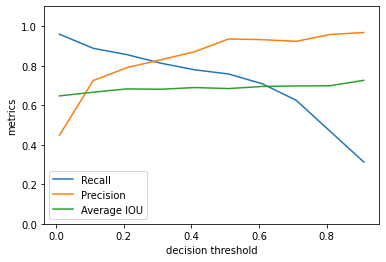

In [26]:
plt.plot(thres_range, recalls)
plt.plot(thres_range, precisions)
plt.plot(thres_range, average_iou)


plt.xlabel('decision threshold')
plt.ylabel('metrics')
plt.ylim(0, 1.1)

plt.legend(['Recall', 'Precision', 'Average IOU'])
#plt.savefig('YOLO/no_FR/precision_recall_B_MSH.png')

In [40]:
wind = np.load('/DATA/nguyen/timeSeries_interval/Wind_FR.npy', allow_pickle=True)

X = np.zeros((len(wind), wind.shape[1], wind.shape[2]+1))


for i, x in enumerate(wind):
    mag = np.linalg.norm(x, axis=1)
    X[i,:, :3] = x/max(mag)
    X[i, :, 3] = mag/max(mag)
      
    
    
y_wind = np.load('/DATA/nguyen/timeSeries_interval/Wind_FR_label.npy', allow_pickle=True)




Y_pred = model.predict(X, verbose=1)

for i in range(len(X)):
    fig, ax = plot_boxes(X[i], y_wind[i, :], Y_pred[i], 0.5)
    ax[0].set_ylabel('Normalized B', fontsize=12)
    ax[0].legend(['Bx', 'By', 'Bz'], fontsize=12)
    ax[1].set_ylim(-0.1, 1.1)
    ax[0].set_ylim(-1, 1)
    ax[1].set_xlabel('Timestep', fontsize=12)
    plt.savefig('YOLO/no_FR/wind_pred'+str(i)+'.jpg')
    plt.close()

21/21 [==============================] - 0s 2ms/step


In [34]:
y_wind.shape

(653, 2080)

In [39]:
def plot_boxes(data, label, matrice, thres_proba, plot_pred=True):
    fig, ax = plt.subplots(nrows=2, figsize=(10, 10))
    ax[0].plot(data[:, 0])
    ax[0].plot(data[:, 1])
    ax[0].plot(data[:, 2])
    
    ax[1].plot(label)
    if plot_pred is True:
        for i in range(len(matrice)):
            if matrice[i, 2]>thres_proba:
                plt.axvspan((i+matrice[i, 0])*160-matrice[i, 1]*len(label)/2, (i+matrice[i, 0])*160+matrice[i, 1]*len(label)/2, color='red', alpha=0.2)
    return fig, ax